# [Projet 7: Réalisez des indexations automatiques d’images](https://openclassrooms.com/fr/projects/realisez-des-indexations-automatiques-d-images)
(parcours data: [here](https://openclassrooms.com/paths/63-data-scientist))

Resources:
- this [tutorial](https://medium.com/@sakshamvikram/dog-breed-classification-using-transfer-learning-beginners-guide-6e6262533058) for transfer learning

# --- DRAFT

## Intelligence

Resources:
- [tutorial on kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words) (I did this basically on my own, but look at the features with scikit-learn section)

### Imports

In [2]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(HOME+'Documents/GitHub/OCDataSciencePath/Project6/Work/')    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import pandas as pd
import time
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [4]:
from Pkg.helper import avg_jacard, hamming_score, plotCV # only works if correct working dirrectory

### Data

In [5]:
if HOST == 'Arthurs-MacBook-Pro.local':
    pathToDataDir = HOME+'Documents/Dropbox/Transit/OCDataScienceData/Project6/Data/'    # @home
    pathToIntellDir = HOME+'Documents/Dropbox/Transit/OCDataScienceData/Project6/Intelligence/'    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))

In [6]:
filename = '100k_forLearning.npz'

tmp = np.load(pathToDataDir+filename)
x_train,x_test,y_train,y_test = tmp['arr_0'],tmp['arr_1'],tmp['arr_2'],tmp['arr_3']

In [7]:
x_train,x_train.shape

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), (80063, 597))

In [8]:
x_test,x_test.shape

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), (20046, 597))

In [9]:
y_train,y_train.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), (80063, 20))

In [10]:
y_test,y_test.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ..., 
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]]), (20046, 20))

### Explore models

Use [OneVsRest](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) to perform multi-label (as in [here](https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5),...).

**Notes:**
- the tags are heavily imbalanced -> predicts 0 if we do nothing for it

In [11]:
x_t,x_v,y_t,y_v = train_test_split(x_train,y_train,test_size=0.2,random_state=8)

In [12]:
ovr = OneVsRestClassifier(LinearSVC(penalty='l2',
                                    loss='squared_hinge',
                                    dual=False,
                                    C=10, # 0.1, #1.0,
                                    fit_intercept=True,
                                    class_weight='balanced',
                                    random_state=8))

tic = time.time()
ovr.fit(x_t,y_t)
print('done: took {}s'.format(np.round(time.time()-tic,2)))

done: took 20.04s


*full batch linear SVC: depending on parameters like `loss` and `penalty`, it is too long for full data*  
-> OK **only** setup with reasonable speed (still a function of `C` but reasonable):
`penalty='l2',loss='squared_hinge',dual=False`

In [13]:
ovrlsvc_base = OneVsRestClassifier(LinearSVC(penalty='l2',
                                             loss='hinge',
                                             C=1,
                                             dual=False, # prefer dual=False when n_samples > n_features.
                                             fit_intercept=True,
                                             class_weight='balanced',
                                             random_state=8))
# ovrlsvc_base.get_params() # gridsearchable parameters...
param_grid = {
    'estimator__penalty': ['l2'],
    'estimator__loss': ['squared_hinge'],

    'estimator__C': [0.01,0.1,1,10,100,1000,10000],
    'estimator__class_weight': ['balanced',None]
}

cv = 4
n_jobs = None # None <=> 1 # many problems with multuprocessing: https://github.com/scikit-learn/scikit-learn/issues/2889
ovrlsvc_cv = GridSearchCV(ovrlsvc_base,
                          param_grid=param_grid,
                          scoring=make_scorer(avg_jacard,greater_is_better=True),
                          n_jobs=n_jobs,
                          refit=True,
                          cv=cv,
                          verbose=1,
                          return_train_score=True)

In [14]:
tic = time.time()
ovrlsvc_cv.fit(x_t,y_t) # keep x_v for 'test'
print('done: took {}s'.format(np.round(time.time()-tic,2)))

# done: took 862.39s

Fitting 4 folds for each of 14 candidates, totalling 56 fits


[Parallel(n_jobs=None)]: Done  56 out of  56 | elapsed: 14.1min finished


done: took 860.8s


*SGD: not realy minibatch wihtout many efforts*

In [102]:
# ovrsgd_base = OneVsRestClassifier(SGDClassifier(loss='hinge',
#                                                 penalty='l2',
#                                                 alpha=0.0001,
#                                                 l1_ratio=0,
#                                                 fit_intercept=True,
#                                                 max_iter=None,
#                                                 tol=1e-3,
#                                                 shuffle=True,
#                                                 verbose=0,
#                                                 n_jobs=1,
#                                                 random_state=8,
#                                                 learning_rate='optimal',
#                                                 eta0=0.0,
#                                                 power_t=0.5,
#                                                 class_weight='balanced',
#                                                 warm_start=False,
#                                                 average=False))
# ovrsgd_base.get_params() # gridsearchable parameters...
# param_grid = {
#     'estimator__tol': [1e-3,1e-1],  
    
# #     'estimator__penalty': ['l1','l2'],
#     'estimator__penalty': ['l2'],
    
# #     'estimator__alpha': [.001, .01, .1, 1, 10, 100],
#     'estimator__alpha': [.1, 1, 10],

# #     'estimator__class_weight': ['balanced',None]
#     'estimator__class_weight': ['balanced']
# }

# cv = 4
# n_jobs = 1
# ovrsgd_cv = GridSearchCV(ovrsgd_base,
#                          param_grid=param_grid,
#                          scoring=make_scorer(avg_jacard,greater_is_better=True),
#                          n_jobs=n_jobs,
#                          refit=True,
#                          cv=cv,
#                          verbose=2,
#                          return_train_score=True)

In [ ]:
# tic = time.time()
# ovrsgd_cv.fit(x_t,y_t) # keep x_v for 'test'
# print('done: took {}s'.format(np.round(time.time()-tic,2)))

*bagged models from smaller data (at least [one guy](https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python#32025662) says it's possible)- let's see:*

In [115]:
# lsvc_base = LinearSVC(penalty='l2',
#                       loss='squared_hinge',
#                       C=1,
#                       dual=False, # prefer dual=False when n_samples > n_features.
#                       fit_intercept=True,
#                       class_weight='balanced',
#                       random_state=8)
# bagged_lsvc_base = BaggingClassifier(base_estimator=lsvc_base,
#                                         n_estimators=10,
#                                         max_samples=1.0,
#                                         max_features=1.0,
#                                         bootstrap=False,
#                                         bootstrap_features=False,
#                                         oob_score=False,
#                                         warm_start=False,
#                                         n_jobs=1,
#                                         random_state=8,
#                                         verbose=2)
# ovr_bagged_lsvc_base = OneVsRestClassifier(bagged_lsvc_base)

# # ovr_bagged_lsvc_base.get_params() # gridsearchable parameters...
# param_grid = {
# #     'estimator__penalty': ['l1','l2'],
#     'estimator__base_estimator__penalty': ['l1'],
    
# #     'estimator__C': [.001, .01, .1, 1, 10, 100],
#     'estimator__base_estimator__C': [.1, 1, 10],

# #     'estimator__class_weight': ['balanced',None]
#     'estimator__base_estimator__class_weight': ['balanced'],
    
#     'estimator__max_samples': [1000, 10000],
#     'estimator__n_estimators': [10, 50],
# }

# cv = 4
# n_jobs = 4
# bagged_ovrlsvc_cv = GridSearchCV(ovr_bagged_lsvc_base,
#                                  param_grid=param_grid,
#                                  scoring=make_scorer(avg_jacard,greater_is_better=True),
#                                  n_jobs=n_jobs,
#                                  refit=True,
#                                  cv=cv,
#                                  verbose=2,
#                                  return_train_score=True)

In [118]:
# tic = time.time()
# bagged_ovrlsvc_cv.fit(x_t,y_t) # keep x_v for 'test'
# print('done: took {}s'.format(np.round(time.time()-tic,2)))

*but [the guy](https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python#32025662) also proposes RandomForest (again...) to tackle all aspects at once - let's see:*

**BUT** scikit's RF does **NOT** perform subsetting accros samples :(

In [124]:
# # but keep in mind it will be hard for the tree to grow if only few features are useful among my many...
# # so maybe consider Pipelining and reducing dimensionalty?
# rf_base = RandomForestClassifier(n_estimators=10,
#                                  criterion='gini',
#                                  max_depth=None,
#                                  min_samples_split=2,
#                                  min_samples_leaf=1,
#                                  min_weight_fraction_leaf=0.0,
#                                  max_features=x_t.shape[1], # (equibalent to None) here most of the use of RF may be lost
#                                  max_leaf_nodes=None,
#                                  min_impurity_decrease=0.0,
#                                  min_impurity_split=None, 
#                                  bootstrap=False,
#                                  oob_score=False,
#                                  n_jobs=1,
#                                  random_state=None,
#                                  verbose=0,
#                                  warm_start=False,
#                                  class_weight='balanced')

# rf_base.get_params() # gridsearchable parameters...
# param_grid = {
#     'max_depth': [5,10],
#     'max_features': ['auto',x_t.shape[1]],
#     'class_weight': ['balanced'],  
#     'n_estimators': [10, 50],
# }

# cv = 4
# n_jobs = 4
# rf_base_cv = GridSearchCV(rf_base,
#                           param_grid=param_grid,
#                           scoring=make_scorer(avg_jacard,greater_is_better=True),
#                           n_jobs=n_jobs,
#                           refit=True,
#                           cv=cv,
#                           verbose=2,
#                           return_train_score=True)

In [139]:
# tic = time.time()
# rf_base_cv.fit(x_t,y_t) # keep x_v for 'test'
# print('done: took {}s'.format(np.round(time.time()-tic,2)))

# # done: took 3022.61s

*try a light model: the good old LogisticRegression!*

In [144]:
# ovrlr_base = OneVsRestClassifier(LogisticRegression(penalty='l2',
#                                                     dual=False, # prefer dual=False when n_samples > n_features
#                                                     tol=0.0001,
#                                                     C=1.0,
#                                                     fit_intercept=True,
#                                                     intercept_scaling=1,
#                                                     class_weight='balanced',
#                                                     random_state=8,
#                                                     solver='saga',
#                                                     max_iter=100,
#                                                     verbose=2,
#                                                     warm_start=False,
#                                                     n_jobs=1))
# # ovrlr_base.get_params() # gridsearchable parameters...
# param_grid = {
# #     'estimator__penalty': ['l1','l2'],
#     'estimator__penalty': ['l2'],
    
# #     'estimator__C': [.001, .01, .1, 1, 10, 100],
#     'estimator__C': [1],

# #     'estimator__class_weight': ['balanced',None]
#     'estimator__class_weight': ['balanced']
# }

# cv = 4
# n_jobs = 4
# ovrlr_cv = GridSearchCV(ovrlr_base,
#                         param_grid=param_grid,
#                         scoring=make_scorer(avg_jacard,greater_is_better=True),
#                         n_jobs=n_jobs,
#                         refit=True,
#                         cv=cv,
#                         verbose=2,
#                         return_train_score=True)

In [146]:
# tic = time.time()
# ovrlr_cv.fit(x_t,y_t) # keep x_v for 'test'
# print('done: took {}s'.format(np.round(time.time()-tic,2)))

*wow! Even the Logistic Regression is problematic (due to the OvR with 37 classes...), what about Ridge?*

In [153]:
# ovrridge_base = OneVsRestClassifier(RidgeClassifier(alpha=1.0,
#                                           fit_intercept=True,
#                                           normalize=False,
#                                           copy_X=True,
#                                           max_iter=None,
#                                           tol=0.001,
#                                           class_weight='balanced',
#                                           solver='saga', # saga: not exact actually; lsqr: it is the fastest and uses an iterative procedure
#                                           random_state=8))
# # ovrridge_base.get_params() # gridsearchable parameters...
# param_grid = {
# #     'estimator__C': [.001, .01, .1, 1, 10, 100],
#     'estimator__alpha': [1],

# #     'estimator__class_weight': ['balanced',None]
#     'estimator__class_weight': ['balanced']
# }

# cv = 4
# n_jobs = 4
# ovrridge_cv = GridSearchCV(ovrridge_base,
#                            param_grid=param_grid,
#                            scoring=make_scorer(avg_jacard,greater_is_better=True),
#                            n_jobs=n_jobs,
#                            refit=True,
#                            cv=cv,
#                            verbose=2,
#                            return_train_score=True)

In [155]:
# tic = time.time()
# ovrlr_cv.fit(x_t,y_t) # keep x_v for 'test'
# print('done: took {}s'.format(np.round(time.time()-tic,2)))

### Assess the model

In [20]:
model_cv = ovrlsvc_cv

In [21]:
# pd.DataFrame(model_cv.cv_results_)

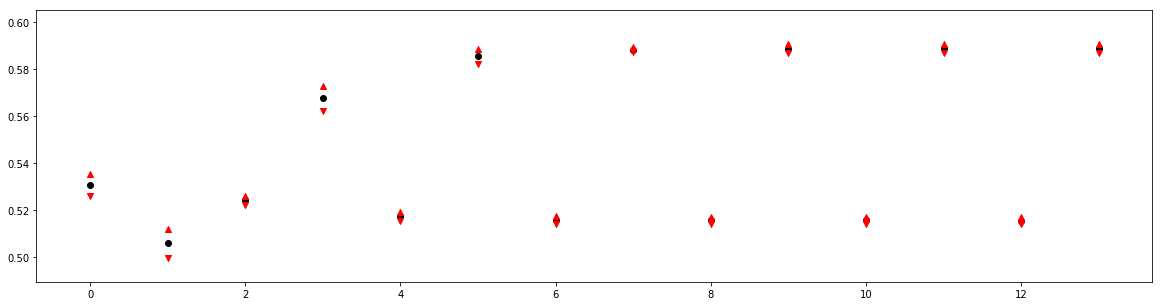

In [22]:
plotCV(model_cv,3)

In [23]:
i = 5000000
x_v_ = x_v[:i,:]
y_v_ = y_v[:i,:]

y_hat = model_cv.predict(x_v_)

In [24]:
y_hat,y_hat.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), (16013, 20))

In [25]:
y_v_,y_v_.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), (16013, 20))

*Some [metrics](https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics):*

In [26]:
print(avg_jacard(y_v_,y_hat))

0.584363746123


In [27]:
print(hamming_score(y_v_,y_hat))

0.584363746123


### Save the model

In [30]:
# save model for later us

# ??? got problems in loading a pickled GridSearchCV object in the App context
# so here we really only dump the best estimator
model_ = model_cv.best_estimator_ 

pickle.dump(model_, open(pathToIntellDir+'model.pkl','wb'))